### 2024/05/29 機械学習モデルでの精度に対する追加の解析

##### ▶ライブラリ

In [5]:
import pandas as pd
import numpy as np
import pickle
import requests
import io
import math
import copy
from scipy.stats import gmean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from pipeline_functions import PipelineFunctions
pf = PipelineFunctions()
from view_functions import ViewFunctions
vf = ViewFunctions()

import umap
from sklearn.manifold import TSNE
import seaborn as sns
palette = ['#CC521D', '#4F4AD7', '#39AE3D']

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def show_plot(x, y, color):
    plt.rcParams['font.family'] = 'Times New Roman'
    PLOT_COLOER= 'green'
    FACE_COLOR = 'white'
    PLOT_WIDTH = 0.5
    FIG_SIZE = (10, 5)
    fig, ax = plt.subplots(facecolor=FACE_COLOR, figsize=(FIG_SIZE[0],FIG_SIZE[1]))
    ax.set_ylim([0, 1])    # y方向の描画範囲を指定
    ax.set_facecolor(FACE_COLOR)
    ax.plot(x, y, color=color, linewidth=PLOT_WIDTH)  
    plt.show()
    plt.close()
    return

##### ▶結果データの読み込み

In [2]:
svm = pd.read_csv('../temp/compile_test_csv/compile_test_svm.csv', delimiter=',', index_col=0).reset_index()
knn = pd.read_csv('../temp/compile_test_csv/compile_test_knn.csv', delimiter=',', index_col=0).reset_index()
lgr = pd.read_csv('../temp/compile_test_csv/compile_test_lgr.csv', delimiter=',', index_col=0).reset_index()
rf = pd.read_csv('../temp/compile_test_csv/compile_test_rf.csv', delimiter=',', index_col=0).reset_index()

In [17]:
svm.query('ptcnt_type == 1').query('ptcnt == 3').query('X_col == "startend_seg_cossim"')

,index,kernel,c,gamma,degree,test_recall,test_precision,test_f1,test_accuracy,ptcnt_type,ptcnt,X_col
72,0,rbf,1,0.01,1,1.000000,0.622581,0.767396,0.622581,1,3,startend_seg_cossim
73,1,rbf,1,0.10,1,1.000000,0.622581,0.767396,0.622581,1,3,startend_seg_cossim
74,2,rbf,1,0.50,1,0.989637,0.654110,0.787629,0.667742,1,3,startend_seg_cossim
75,3,rbf,1,1.00,1,0.943005,0.657040,0.774468,0.658065,1,3,startend_seg_cossim
76,4,rbf,1,5.00,1,0.948187,0.667883,0.783726,0.674194,1,3,startend_seg_cossim
77,5,rbf,1,20.00,1,0.943005,0.681648,0.791304,0.690323,1,3,startend_seg_cossim
78,6,rbf,5,0.01,1,1.000000,0.622581,0.767396,0.622581,1,3,startend_seg_cossim
79,7,rbf,5,0.10,1,1.000000,0.622581,0.767396,0.622581,1,3,startend_seg_cossim
80,8,rbf,5,0.50,1,0.937824,0.670370,0.781857,0.674194,1,3,startend_seg_cossim
81,9,rbf,5,1.00,1,0.953368,0.669091,0.786325,0.677419,1,3,startend_seg_cossim


##### ▶テストデータに対する最大値

In [35]:
score_cols = ['test_f1', 'test_recall', 'test_precision']
result = rf.copy()
max_val= 0
max_index = 0
score_col = 'test_f1'

for i, row in result.iterrows():
    max_index = i if row[score_col] > max_val else max_index
    max_val = row[score_col] if row[score_col] > max_val else max_val
    
print(max_val)
print(max_index)
result[max_index:max_index+1]

0.979381443298969
37544


,index,criterion,max_features,random_state,n_estimators,max_depth,max_leaf_nodes,test_recall,test_precision,test_f1,test_accuracy,ptcnt_type,ptcnt,X_col
37544,14,gini,sqrt,1,5,10,50,0.984456,0.974359,0.979381,0.974194,2,28,startend_grad_cossim


##### ▶決定境界を可視化⇒無理そう

C:\Users\ispec\AppData\Local\Temp\ipykernel_14756\4175229585.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embed_X[f'norm_{col}'] = scaler.transform(embed_X[[col]])
C:\Users\ispec\AppData\Local\Temp\ipykernel_14756\4175229585.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embed_X[f'norm_{col}'] = scaler.transform(embed_X[[col]])
C:\Users\ispec\AppData\Local\Temp\ipykernel_14756\4175229585.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

<AxesSubplot: xlabel='tsne_ax0', ylabel='tsne_ax1'>

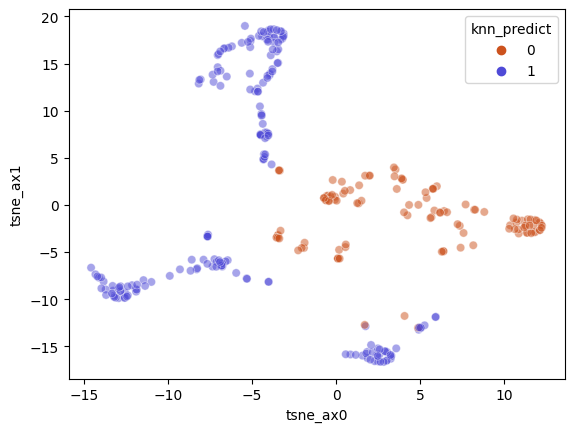

In [42]:
import umap
from sklearn.manifold import TSNE
predict = pd.read_csv('../temp/fail_classify_stroke.csv', delimiter=',', index_col=0)
embed_col = [f'feature_{i}' for i in [0, 1, 2, 3, 4, 5]]
embed_X = predict[embed_col]

scaler = MinMaxScaler()
for col in embed_X:
    train_minmax = scaler.fit(embed_X[[col]])
    embed_X[f'norm_{col}'] = scaler.transform(embed_X[[col]])
    del embed_X[col]
    
np_embed_X = embed_X.to_numpy()

##### t_SNE #####
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, metric='euclidean', init='pca', random_state=1)
tsne_result = tsne.fit_transform(np_embed_X)
predict['tsne_ax0'] = tsne_result[:, 0:1]
predict['tsne_ax1'] = tsne_result[:, 1:2]

sns.scatterplot(x='tsne_ax0', y='tsne_ax1', hue=predict['knn_predict'], data=predict, palette=palette, alpha=0.5)

##### ▶次元圧縮して決定境界を可視化⇒難しそう

In [32]:
from sklearn.svm import SVC

### 最適パラメータ ###
TRAIN_TEST_SPLIT_SEED = 1
PTCNT_TYPE = 1
PTCNT = 3
X_COL = 'startend_seg_cossim'
Y_COL = 'is_good_saito'
KERNEL = 'rbf'
DEGREE = 1
C = 5
GAMMA = 0.1

### モデルでの推論 ###
data = pd.read_csv(f'../temp/eachpt_feature/{PTCNT_TYPE}_{PTCNT}_{X_COL}.csv', delimiter=',', index_col=0)
X = data.copy()
y = data[Y_COL]
# 学習データとテストデータを725:310に分割する
train_valid, test, y_train_valid, y_test = train_test_split(X, y, train_size=725, shuffle=True, stratify=y, random_state=TRAIN_TEST_SPLIT_SEED)

### 説明変数と目的変数に分ける ###
X_col = [col for col in train_valid if 'feature_' in col]
y_col = 'is_good_saito'
train_valid_X = train_valid.copy()[X_col]
train_valid_y = train_valid.copy()[y_col]
test_X = test.copy()[X_col]
test_y = test.copy()[y_col]

### 学習データのスケーリング(正規化, 学習データのmin, maxを検証データとテストデータに適用) ###
scaler = MinMaxScaler()
for col in train_valid_X:
    train_minmax = scaler.fit(train_valid_X[[col]])
    train_valid_X[f'norm_{col}'] = scaler.transform(train_valid_X[[col]])
    test_X[f'norm_{col}'] = scaler.transform(test_X[[col]])
    del train_valid_X[col]
    del test_X[col]

### モデルへの入力形式に変換する ###
train_valid_X = train_valid_X.to_numpy()
train_valid_y = train_valid_y.to_numpy()
test_X = test_X.to_numpy()
test_y = test_y.to_numpy()

# ##### 学習データに対するt_SNE #####
# tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, metric='euclidean', init='pca', random_state=1)
# tsne_result = tsne.fit_transform(train_valid_X)
# train_valid['tsne_ax0'] = tsne_result[:, 0:1]
# train_valid['tsne_ax1'] = tsne_result[:, 1:2]

# ##### テストデータに対するt_SNE #####
# tsne_result = tsne.fit_transform(test_X)
# train_valid['tsne_ax0'] = tsne_result[:, 0:1]
# train_valid['tsne_ax1'] = tsne_result[:, 1:2]

# ##### 説明変数と目的変数に分ける #####
# X_col = [col for col in train_valid if 'tsne_ax' in col]
# y_col = 'is_good_saito'
# train_valid_X = train_valid.copy()[X_col]
# train_valid_y = train_valid.copy()[y_col]
# test_X = test.copy()[X_col]
# test_y = test.copy()[y_col]

# ##### 次元圧縮後の特徴量を正規化する #####
# scaler = MinMaxScaler()
# for col in train_valid_X:
#     train_minmax = scaler.fit(train_valid_X[[col]])
#     train_valid_X[f'norm_{col}'] = scaler.transform(train_valid_X[[col]])
#     test_X[f'norm_{col}'] = scaler.transform(test_X[[col]])
#     del train_valid_X[col]
#     del test_X[col]
    
# ### モデルへの入力形式に変換する ###
# train_valid_X = train_valid_X.to_numpy()
# train_valid_y = train_valid_y.to_numpy()
# test_X = test_X.to_numpy()
# test_y = test_y.to_numpy()

### モデルを生成する ###
model = SVC(kernel=KERNEL, C=C, gamma=GAMMA, degree=DEGREE, probability=True)
### モデルを学習させる ###
result = model.fit(train_valid_X, train_valid_y)
### 検証データで精度を算出する ###
test_pred = model.predict(test_X)
### 各指標の値(testデータに対する) ###
recall = recall_score(test_y, test_pred, average=None)[1]
precision = precision_score(test_y, test_pred, average=None)[1]
f1 = f1_score(test_y, test_pred, average=None)[1]
accuracy = accuracy_score(test_y, test_pred)

c:\Users\ispec\MyWorkSpace\python\drawing_2024\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### ▶解析対象データ以外でのデータを入力した結果を確かめる（2015年度の永松さん）

In [2]:
# 永松若葉，略してnw
drawing_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0).query('is_asai == 1')
nw_box_info  = drawing_info.query('name == "永松若葉"').query('motif == "紙箱"').query('times == 1')

In [3]:
drawing_id = nw_box_info['drawing_id'].iloc[0]
rotate_type = nw_box_info['rotate_type'].iloc[0]
nw_box = pf.get_normalized_data(f'../data/all_tsv/id_{drawing_id}.tsv', rotate_type)

nw = pd.DataFrame({
    'drawing_id': nw_box['drawing_id'],
    'stroke_id': nw_box['stroke_id'],
    'shape_int': nw_box['shape_int'],
    'ptcnt': [len(coord) for coord in nw_box['rotated_x']],
    'rotated_x': nw_box['rotated_x'],
    'rotated_y': nw_box['rotated_y'],
    'normalized_x': nw_box['size_unified_x'],
    'normalized_y': nw_box['size_unified_y']
})

##### ▶特徴量を導出する関数

In [ ]:
for pt_cnt in range(3, 84):
    data = pd.read_pickle(f'../data/data_unify_ptcnt/ptcnt_{pt_cnt}.pkl')
    ptcnt_type = 2
    copy_data = data.copy()
    org_coord = [calc_org_coord(x, y) for x, y in zip(data[PTCNT[ptcnt_type][0]], data[PTCNT[ptcnt_type][1]])]
    segment_vec  = [calc_segment_vec(x, y) for x, y in zip(data[PTCNT[ptcnt_type][0]], data[PTCNT[ptcnt_type][1]])]
    segment_cossim  = [calc_segment_cossim(x, y) for x, y in zip(data[PTCNT[ptcnt_type][0]], data[PTCNT[ptcnt_type][1]])]
    startend_seg_cossim = [calc_startend_seg_cossim(x, y) for x, y in zip(data[PTCNT[ptcnt_type][0]], data[PTCNT[ptcnt_type][1]])]
    feature = pd.DataFrame({
        'org_coord': org_coord,
        'segment_vec': segment_vec,
        'segment_cossim': segment_cossim,
        'startend_seg_cossim': startend_seg_cossim
    })
    
    # startend_grad_cossim = [calc_startend_grad_cossim(x, y, grad_x, grad_y) for x, y, grad_x, grad_y in zip(
    #     data[''], data['equal_interval_y'], data['equal_interval_vecx'], data['equal_interval_vecy'])]
    
    # segment_grad_cossim = [calc_segment_grad_cossim(grad_x, grad_y) for grad_x, grad_y in zip(
    #     data['equal_interval_vecx'], data['equal_interval_vecy'])]
    
    # feature = pd.DataFrame({
    #     'segment_grad_cossim': segment_grad_cossim,
    #     'startend_grad_cossim': startend_grad_cossim
    # })
    
    data_ptcnt_feature = pd.concat([copy_data, feature], axis=1)
    data_ptcnt_feature.to_pickle(f'../temp/grad_feature/{ptcnt_type}_{pt_cnt}.pkl')

    print(pt_cnt, ' | ', ptcnt_type)

In [4]:
SAMPLE_PT_CNT = 5
### 特徴点抽出方法1
# 長さで等間隔に抽出
equal_interval_x = [pf.get_sampled_coord_vector_by_length(x, y, SAMPLE_PT_CNT)[0] for x, y in zip(data['normalized_x'], data['normalized_y'])]
equal_interval_y = [pf.get_sampled_coord_vector_by_length(x, y, SAMPLE_PT_CNT)[1] for x, y in zip(data['normalized_x'], data['normalized_y'])]

equal_interval_vecx = [pf.get_sampled_coord_vector_by_length(x, y, SAMPLE_PT_CNT)[2] for x, y in zip(data['normalized_x'], data['normalized_y'])]
equal_interval_vecy = [pf.get_sampled_coord_vector_by_length(x, y, SAMPLE_PT_CNT)[3] for x, y in zip(data['normalized_x'], data['normalized_y'])]

### 特徴点抽出方法2
# 座票数が指定した数より小さい場合：線分の中点に点を埋める
# 座票数が指定した数と同じ場合：そのまま
# 座票数が指定した数より大きい場合：線分間のコサイン類似度が最も高い箇所から座標を取り除く
smaller_cossim_x = []
smaller_cossim_y = []
for i, row in data.iterrows():
    if row['pt_cnt'] < SAMPLE_PT_CNT:
        over_x, over_y = pf.get_oversampled_coord(row['normalized_x'], row['normalized_y'], SAMPLE_PT_CNT)
        smaller_cossim_x.append(over_x)
        smaller_cossim_y.append(over_y)      
    elif row['pt_cnt'] == SAMPLE_PT_CNT:
        smaller_cossim_x.append(row['normalized_x'])
        smaller_cossim_y.append(row['normalized_y'])
    else:
        down_x, down_y = pf.get_downsampled_coord_by_cossim_sequentially(row['normalized_x'], row['normalized_y'], SAMPLE_PT_CNT)
        smaller_cossim_x.append(down_x)
        smaller_cossim_y.append(down_y)
        
### 特徴点抽出方法3
# 座票数が指定した数より小さい場合：線分の中点に点を埋める
# 座票数が指定した数と同じ場合：そのまま
# 座票数が指定した数より大きい場合：座標の順番が等間隔になるように抽出する
equal_coord_intervel_x = []
equal_coord_intervel_y = []
for i, row in data.iterrows():
    if row['pt_cnt'] < SAMPLE_PT_CNT:
        over_x, over_y = pf.get_oversampled_coord(row['normalized_x'], row['normalized_y'], SAMPLE_PT_CNT)
        equal_coord_intervel_x.append(over_x)
        equal_coord_intervel_y.append(over_y)      
    elif row['pt_cnt'] == SAMPLE_PT_CNT:
        equal_coord_intervel_x.append(row['normalized_x'])
        equal_coord_intervel_y.append(row['normalized_y'])
    else:
        down_x, down_y = pf.get_downsampled_coord_by_coordnum(row['normalized_x'], row['normalized_y'], SAMPLE_PT_CNT)
        equal_coord_intervel_x.append(down_x)
        equal_coord_intervel_y.append(down_y)

features = pd.DataFrame({
    'equal_interval_x': equal_interval_x,
    'equal_interval_y': equal_interval_y,
    'equal_interval_vecx': equal_interval_vecx,
    'equal_interval_vecy': equal_interval_vecy,
    'smaller_cossim_x': smaller_cossim_x,
    'smaller_cossim_y': smaller_cossim_y,
    'equal_coord_intervel_x': equal_coord_intervel_x,
    'equal_coord_intervel_y': equal_coord_intervel_y
})

# data_plus_sample = pd.concat([data, features], axis=1)

# data_plus_sample.to_pickle(f'../temp/data_unify_ptcnt/ptcnt_{SAMPLE_PT_CNT}.pkl')

print(SAMPLE_PT_CNT)

,drawing_id,stroke_id,shape_int,rotate_type,pt_cnt,rotated_x,rotated_y,normalized_x,normalized_y,saito_label,is_good_saito,is_good_rulebase,equal_interval_x,equal_interval_y,equal_interval_vecx,equal_interval_vecy,smaller_cossim_x,smaller_cossim_y,equal_coord_intervel_x,equal_coord_intervel_y
0,100,1035,1,90,6,"[177.6375, 178.0875, 179.025, 183.75, 189.2625...","[193.575, 192.975, 192.29999999999998, 189.787...","[0.0, 12.144578313253472, 37.445783132530586, ...","[197.34939759036146, 181.15662650602425, 162.9...",straight,1,1,"[0.0, 200.30378722189496, 420.0]","[197.34939759036146, 80.22725276257131, 0.0]",[0.9213992321488654],[-0.38861736321924845],"[0.0, 12.144578313253472, 420.0]","[197.34939759036146, 181.15662650602425, 0.0]","[0.0, 164.96385542168707, 420.0]","[197.34939759036146, 95.13253012048209, 0.0]"
1,100,1062,2,90,8,"[155.85, 143.625, 137.8125, 128.70000000000002...","[330.97499999999997, 337.2, 340.425, 345.1125,...","[420.0, 251.79361179361175, 171.81818181818173...","[0.0, 85.65110565110604, 130.02457002457075, 1...",straight,1,1,"[420.0, 186.2280092464814, 41.793611793611745]","[0.0, 122.02943996757861, 169.23832923832953]",[-0.8744232505671159],[0.4851638680565968],"[420.0, 0.0, 41.793611793611745]","[0.0, 208.45208845208907, 169.23832923832953]","[420.0, 12.38329238329208, 41.793611793611745]","[0.0, 207.4201474201482, 169.23832923832953]"
2,100,1071,2,90,8,"[163.275, 160.38750000000002, 153.4875, 150.52...","[325.2375, 326.625, 330.4875, 331.875, 332.512...","[420.0, 339.1500000000003, 145.95000000000016,...","[0.0, 38.84999999999968, 147.0, 185.8499999999...",straight,1,1,"[420.0, 169.44458213735243, 75.59999999999968]","[0.0, 133.84814152093864, 138.59999999999968]",[-0.8725868718184436],[0.48845895542010803],"[420.0, 0.0, 75.59999999999968]","[0.0, 202.64999999999873, 138.59999999999968]","[420.0, 14.70000000000016, 75.59999999999968]","[0.0, 203.69999999999936, 138.59999999999968]"
3,100,1092,1,90,7,"[203.925, 203.25, 200.55, 197.47500000000002, ...","[267.0, 267.6375, 270.15, 272.625, 273.4124999...","[420.0, 379.7872340425526, 218.93617021276629,...","[0.0, 37.97872340425458, 187.65957446808346, 3...",straight,1,1,"[420.0, 187.58415949129596, 31.276595744681142]","[0.0, 212.89411968292575, 411.06382978723207]",[-0.7790116852629152],[0.6270094052116226],"[420.0, 0.0, 31.276595744681142]","[0.0, 413.2978723404249, 411.06382978723207]","[420.0, 35.74468085106513, 31.276595744681142]","[0.0, 335.1063829787229, 411.06382978723207]"
4,100,111,1,90,9,"[184.1625, 184.9125, 190.4625, 191.4, 193.875,...","[49.76249999999999, 54.44999999999999, 76.7624...","[0.0, 5.944798301486198, 49.93630573248416, 57...","[0.0, 37.15498938428874, 214.01273885350315, 2...",straight,1,1,"[0.0, 48.90543636450788, 96.30573248407646]","[0.0, 209.86836538089582, 420.0]",[0.24138417836726705],[0.970429636003538],"[0.0, 95.7112526539277, 96.30573248407646]","[0.0, 411.380042462845, 420.0]","[0.0, 76.98513800424631, 96.30573248407646]","[0.0, 337.0700636942675, 420.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,960,1801,2,90,11,"[109.1625, 108.82500000000002, 108.07500000000...","[79.61250000000001, 79.80000000000001, 80.6625...","[52.49999999999986, 39.375000000000725, 10.208...","[0.0, 7.2916666666666785, 40.83333333333273, 6...",complex,0,1,"[52.49999999999986, 170.2789921000782, 392.291...","[0.0, 219.93921607783773, 412.7083333333333]",[0.7893522173763272],[0.6139406135149194],"[52.49999999999986, 402.5000000000004, 392.291...","[0.0, 420.0, 412.7083333333333]","[52.49999999999986, 26.250000000000483, 392.29...","[0.0, 107.9166666666665, 412.7083333333333]"
1031,960,424,4,90,53,"[185.775, 183.82500000000002, 181.200000000000...","[314.325, 317.625, 322.2375, 324.4124999999999...","[47.727272727272734, 32.68595041322323, 12.438...","[334.6694214876033, 360.12396694214885, 395.70...",complex,0,0,"[47.727272727272734, 179.24386719197685, 164.8...","[334.6694214876033, 99.56015055408542,